# Dino Bektesevic Exoplanets HW 3 
March 1st 2019

In [1]:
import copy
import collections 

import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

import astropy.units as u
import astropy.constants as c

import rebound

%matplotlib inline

## 1. Familiarize yourself with initializing and running a planetary system

First we define some quantities for our system. I picked GJ 876 to test rebound code on. According to the [manual](https://rebound.readthedocs.io/en/latest/ipython/Units.html) the default units are set such that $G=1$ (i.e. AU, $M_{sun}$, year/$2\pi$ and radians). To that end a series of conversion coefficients are defined.

In [2]:
mjup2msun = (c.M_jup/c.M_sun).value
mearth2msun = (c.M_earth/c.M_sun).value
ms2auyr = (u.m/u.s).to(u.AU/u.yr)
days2yr = u.day.to(u.yr)
deg2rad = 0.0174533

Annoyingly Rebound will not accept parameters like K into their `Particle` class. But we want a way to carry that value and any additional information we might find useful alon with our `Planet`. So we write a class that will do that for us, but will stil lbe easy to use with Rebound.

In [3]:
class Planet(collections.Mapping):
    """Class that represents a planet. 
    
    This is a broader definition than the one used by Rebound to define their particles.
    Namely this class keeps track of parameters like P and K, which rebound can not accept.
    
    To make use with rebound easier, the unpacking operator has been overriden to only return
    values Rebound accepts as well.
    """
    def __init__(self, m, e, a, i, w, M, K, P):
        self.m = m
        self.e = e
        self.a = a
        self.inc = i
        self.omega = w
        self.M = M
        self.K = K  
        self.P = P
        
    def __iter__(self):
        return iter(['m', 'e', 'a', 'inc', 'omega', 'M'])
    
    def __getitem__(self, item):
        return getattr(self, item)
    
    def __len__(self):
        return 1
    
    def __repr__(self):
        retstr = '<{0}.Planet(m={1:.4}, e={2:.4}, a={3:.4}, i={4:.4}, w={5:.4}, M={6:.4}, K={7:.4}, P={8:.4}>'
        return retstr.format(__name__, self.m, self.e, self.a, self.inc, self.omega, self.M, self.K, self.P)

Finally we can define our system following the values read from the Rivera et. al. [paper](https://arxiv.org/pdf/1006.4244.pdf) 

In [44]:
#star = {"m":0.334}
star = {"m":0.32}

pd = Planet(m=6.83*mearth2msun, e=0.20700, a=0.02080665, i=1.02974, w=4.08,  M=6.2,  K=6.56,  P=1.93778*days2yr) 
pc = Planet(m=0.7142*mjup2msun, e=0.25591, a=0.12959000, i=1.02974, w=0.851, M=5.14, K=88.34, P=30.0881*days2yr)
pb = Planet(m=2.2756*mjup2msun, e=0.03240, a=0.20831700, i=1.02974, w=0.878, M=5.68, K=214.0, P=61.1166*days2yr)
pe = Planet(m=14.6*mearth2msun, e=0.05500, a=0.33430000, i=1.02974, w=4.17,  M=5.85, K=3.42,  P=124.260*days2yr)

# order matters if inserting through a for loop!
planets = [pd, pc, pb, pe]

Add the planets to the simulation and plot it to see initial state.

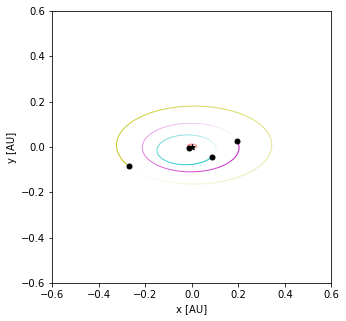

In [5]:
sim = rebound.Simulation()

sim.add(**star)
for planet in planets:
    sim.add(**planet)
sim.move_to_com()

fig = rebound.OrbitPlot(sim,color=True,unitlabel="[AU]",lim=0.6)

Check if integrating the system produces a stable result or if the system seems to be unstable. This is useful to verify that the provided values make sense and are not in the wrong units or that there was a mistake made when converting.

Considering the default unit system used, a single timestep is in reference to $dt=yr/2\pi = 365.256/2\pi = 58.1323$ days. The period of the innermost planet is ~2 days. So a good timestep to use is given as $P/20 ~ 0.1days$ or $0.00172021412dt$. 

A 1000 orbits of the innermost planet takes approximately 2000 days or approximately 5.5 years. Starting from $t=0$ we need to integrate to $t=11\pi$ to get 2000 orbits of closest planet. Note that since this is a reccuring timespan and timestep we declare an array `t` that we can reference later if we ever need it to make a plot.

In [6]:
dt = 0.00172021412

semmajs = {'d':[], 'c':[], 'b':[], 'e':[]}
es = {'d':[], 'c':[], 'b':[], 'e':[]}

In [7]:
while sim.t<11*np.pi:
    sim.integrate(sim.t+dt)
    for name, particle in zip('dcbe', sim.particles[1:]):
        semmajs[name].append(particle.a)
        es[name].append(particle.e)

Plot the results and verify

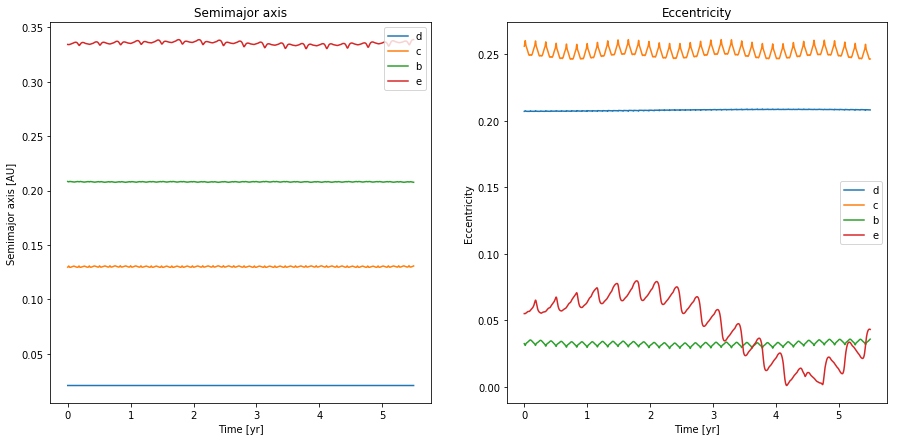

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

t = np.arange(0, sim.t, dt)

for key, val in semmajs.items():
    axes[0].plot(t/(2*np.pi), val, label=key)
axes[0].set_title('Semimajor axis')
axes[0].set_ylabel('Semimajor axis [AU]')
    
for key, val in es.items():
    axes[1].plot(t/(2*np.pi), val, label=key)
axes[1].set_title('Eccentricity') 
axes[1].set_ylabel('Eccentricity')

for ax in axes:
    ax.set_xlabel('Time [yr]')
    ax.legend()

## 2. Look up the parameters of the planet system GJ 876.  Assume the planets’ orbits lie in a plane, and vary the inclination of the system. 

Essentially the above needs to be repeated for a variety of inclinations. Unfortunatelly because of the observational degeneracy between mass and inclinations, every time we change our assumed inclination we need tochange the planetary masses if we want to be consistent. Luckily the system I picked in problem 1 to familiarize myself with Rebound is the exact same one we are required to simulate in problem 2. How fortuitous.

In [9]:
def calcMass(planet, i, mstar=star['m']):
    """For a given Planet instance, target inclination and stellar mass, recalculates the mass 
    of the planet such that the system remains anologous to the one from Rivera et. al. paper.
    Stelar mass is, by default, set to the Rivera et. al. values.
    """
    # note that in declaring the planets parameters we did not convert K to the rebound units 
    # because the dimensions would not work out
    A = planet.m * np.sin(planet.inc) / (mstar + planet.m)**(2/3)
    mnew = planet.m
    B = (mstar + mnew)**(2/3) / np.sin(i)
    m_new = A * B
    return m_new

The three steps described in problem 1 are wrapped into a function which will reduce ammoutn of code.

In [10]:
def simulate(planets, dt=0.00172021412, tmax=11*np.pi):
    """For given planets, timestep dt and total simulated time tmax runs a Rebound simulation
    and returns dictionary of semimajor axes for every timestep.
    """
    sim = rebound.Simulation()

    sim.add(**star)
    for planet in planets:
        sim.add(**planet)
    sim.move_to_com()

    a = {'d':[], 'c':[], 'b':[], 'e':[]}
    
    while sim.t<tmax:
        sim.integrate(sim.t+dt)
        for name, particle in zip('dcbe', sim.particles[1:]):
            a[name].append(particle.a)
            
    return a

Now we can perform a gridsearch over all of the inclinations of interest.

In [11]:
semmajs = []
for i in range(1, 90):
    pplan = copy.deepcopy(planets)
    for planet in pplan:
        newm = calcMass(planet, i*deg2rad)
        planet.inc = i*deg2rad
        planet.m = newm

    semmajs.append(simulate(pplan))

Since I have no better ideas about testing orbit stability I will create plots of all semimajor axes over time and pick the inclinations that have stabile, well separated semimajor axes and label the rest as unstable.

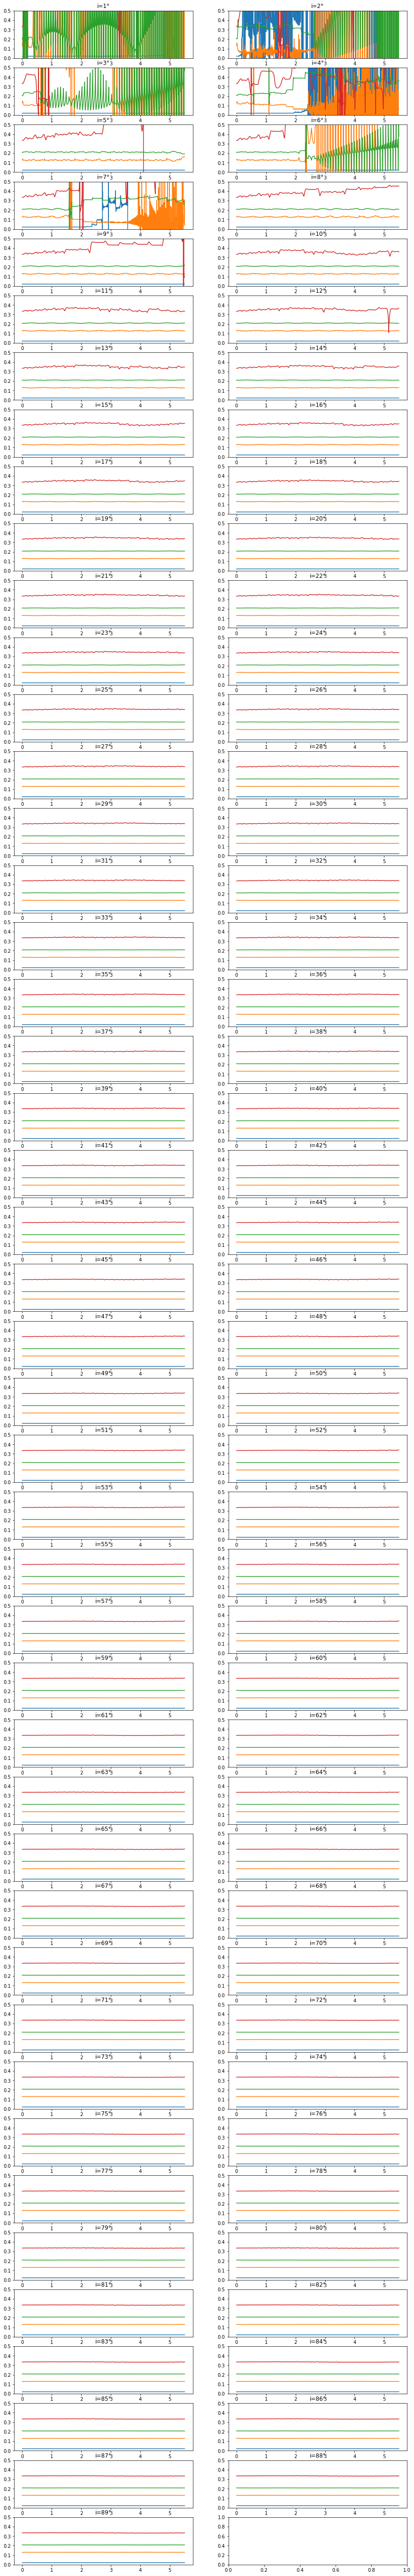

In [12]:
fig, axes = plt.subplots(45, 2, figsize=(15, 100))

i = 1
for ax, model in zip(axes.flatten(), semmajs):
    for pname, pa in model.items():
        ax.plot(t/(2*np.pi), pa, label=pname)
        ax.set_ylim(0, 0.5)
    ax.set_title(f'i={i}°')
    i+=1

### 2.1 At what inclination does the system become unstable after 1000 orbits of the inner planet?

There are several different inclinations at which it would seem the system becomes unstable and they seem to be somewhat mixed with the stable orbits. Up to 13 degrees inclination most of the orbits seem unstable so we focus on that part in more details. Specifically we focus on the $[8, 13>$ range of inclinations since all inclinations prior to 8 degrees seem unstable.

In [14]:
semmajs = []
for i in np.arange(8, 13, 0.05):
    pplan = copy.deepcopy(planets)
    for planet in pplan:
        newm = calcMass(planet, i*deg2rad)
        planet.inc = i*deg2rad
        planet.m = newm

    semmajs.append(simulate(pplan))

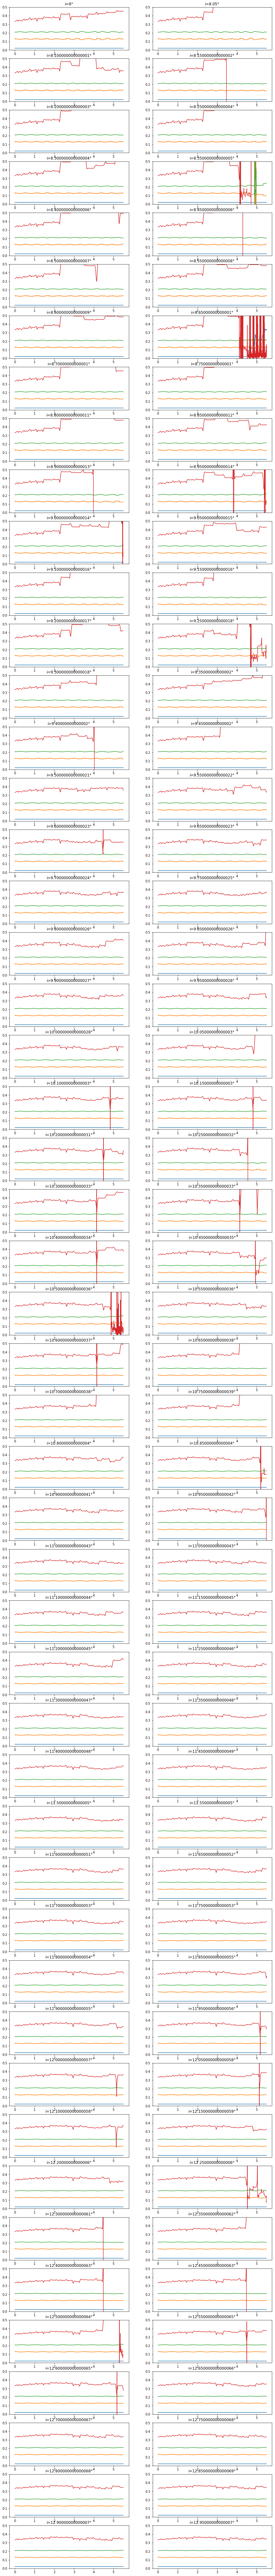

In [15]:
fig, axes = plt.subplots(50, 2, figsize=(15, 150))

i = 8
for ax, model in zip(axes.flatten(), semmajs):
    for pname, pa in model.items():
        ax.plot(t/(2*np.pi), pa, label=pname)
        ax.set_ylim(0, 0.5)
    ax.set_title(f'i={i}°')
    i+=0.05

### 2.2 What upper limit does this place on the planets’ masses?

There seems to be a lonely inclination that produces a stabile configuration at 9.5 degree of inclination but I'll ignore that singular occurence and say the first occurence of stabile orbits occurs above 11 degrees of inclination where a small island of stable orbits exists and then all orbits after 12.6 degrees of inclination seem to be stable. 

In [12]:
for i in [11, 12.6, ]:
    pplan = copy.deepcopy(planets)
    for planet, name in zip(pplan, 'dcbe'):
        newm = calcMass(planet, i*deg2rad)
        print("Planet {0} mass, @ inclination {1}, is {2:0.5f} M_sun. or {3:0.5f} M_earth".format(name, i, newm, 
                                                                                                  newm/mearth2msun))
    print()

Planet d mass, @ inclination 11, is 0.00009 M_sun. or 30.68218 M_earth
Planet c mass, @ inclination 11, is 0.00306 M_sun. or 1019.71313 M_earth
Planet b mass, @ inclination 11, is 0.00976 M_sun. or 3249.03276 M_earth
Planet e mass, @ inclination 11, is 0.00020 M_sun. or 65.58708 M_earth

Planet d mass, @ inclination 12.6, is 0.00008 M_sun. or 26.83757 M_earth
Planet c mass, @ inclination 12.6, is 0.00268 M_sun. or 891.93888 M_earth
Planet b mass, @ inclination 12.6, is 0.00854 M_sun. or 2841.91559 M_earth
Planet e mass, @ inclination 12.6, is 0.00017 M_sun. or 57.36875 M_earth



### 2.3 At what inclination would the planets be seen to transit?

If we assume a grazing passage by the outmost planet in a planar system, which would mean that all interior planets are transiting with a lower impact parameter, we can express the angle of inclination over the sum of the radii of the star and the outmost planet as:

$$\begin{align}
i &= \arccos{\frac{R_s+R_p}{a_p}} \\
i &\approx \arccos{\frac{R_s}{a_p}}
\end{align}$$

In [17]:
rsun2au = 0.00465
rs = 0.32 * rsun2au

i = np.arccos(rs/planets[-1].a)

pplan = copy.deepcopy(planets)
for planet, name in zip(pplan, 'dcbe'):
    newm = calcMass(planet, i)
    print("Planet {0} mass, @ inclination {1}, is {2:0.5f} M_sun. or {3:0.5f} M_earth".format(name, i, newm, 
                                                                                                  newm/mearth2msun))

Planet d mass, @ inclination 1.5663452202634158, is 0.00002 M_sun. or 5.85450 M_earth
Planet c mass, @ inclination 1.5663452202634158, is 0.00058 M_sun. or 194.57245 M_earth
Planet b mass, @ inclination 1.5663452202634158, is 0.00186 M_sun. or 619.95108 M_earth
Planet e mass, @ inclination 1.5663452202634158, is 0.00004 M_sun. or 12.51473 M_earth


## 3. Compute the radial velocity of the star.

First, lets simulate a scenario to store all the time stapms and RVs.

In [22]:
sim = rebound.Simulation()

sim.add(**star)
for planet in planets:
    sim.add(**planet)
sim.move_to_com()

tt, rv = [], []
while sim.t<= 11*np.pi:
    tt.append(sim.t)
    sim.integrate(sim.t+dt)
    rv.append(sim.particles[0].vz)

# the units wont match equations from HW one if yr/2pi is not converted
# including in the velocity unit AU/(yr/2pi)
tt = np.asarray(tt)/(2*np.pi)
rv = np.asarray(rv)*(2*np.pi)

Plot to verify reasonability.

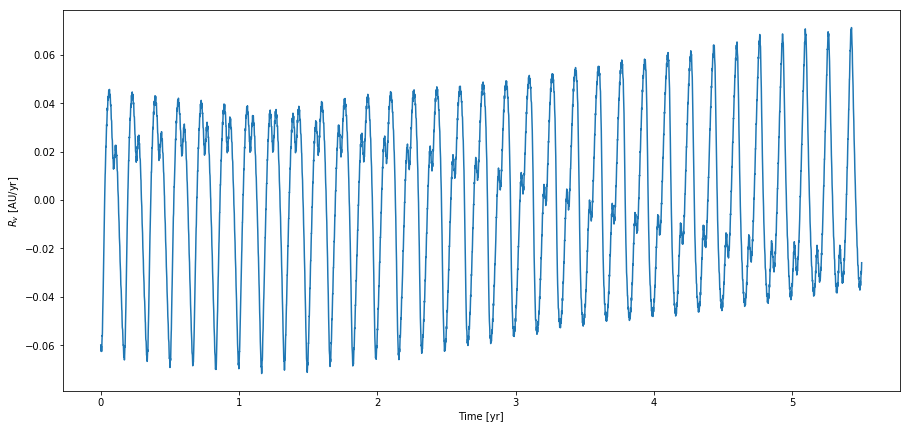

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(tt, rv)
ax.set_xlabel('Time [yr]')
ax.set_ylabel(r'$R_v$ [AU/yr]');

Above is the plot of RVs as simulated by REBOUND using the parameters from Rivera paper. If we want to constrain the orbits based on the simulated RVs ourselves we code that can solve for various orbit parameters.

In [24]:
def newtonsMethod(f, fdot, starting_guess, precission=0.01):
    '''Given a function f and its derivative fdot and an initial
    guess finds its roots.
    '''
    f_x = f(starting_guess)
    fdot_x = fdot(starting_guess)
    
    previous = starting_guess
    following = starting_guess - f_x/fdot_x
                
    while abs(following-previous) > precission:
        previous = following
        following = previous - f(previous)/fdot(previous)
    
    return following

def calcM(t, P, t_p):
    '''Calculates mean annomaly of an orbit given current time, 
    time of periastron and period of the orbit.
    '''
    return (2 * np.pi / P) * (t - t_p)

def keplersEq(E, M, e):
    '''Keplers equation.'''
    return E-e*np.sin(E)-M

def keplersEqDot(E, M, e):
    '''First derivative of keplers equation.'''
    return 1-e*np.cos(E)

def guessE(M, e):
    '''Function that returns the optimal first guess of eccentric annomaly.'''
    return M+0.85*e*np.sign(np.sin(M))

def newtonKeplerSolver(M, e, precission=0.0001):
    '''Wraps the newtonsMethod to solve for the roots of Keplers equation.'''
    E = guessE(M, e)
    f = lambda E: keplersEq(E, M, e)
    fdot = lambda E: keplersEqDot(E, M, e)
    return newtonsMethod(f, fdot, E, precission=precission)

def solveF(M, e, returnAll=False):
    '''Solves for f (see HW 1b)'''
    E = np.zeros(len(M))
    for (i, m) in enumerate(M):
        E[i] = newtonKeplerSolver(m, e)

    f = 2 * np.arctan( np.sqrt( (1+e)/(1-e) ) * np.tan(E/2) )
    if returnAll:
        return f, E, M
    return f

Finally solve for RVs.

In [25]:
def calcRV(t, rv, rverr, pparams):
    '''Given times t, RVs, their errors and planet parameters pparams 
    (period P, eccentricity e, and time of periastron t_p) calculates
    RVs. Providing nplanets 
    '''
    num_planets = int(len(pparams) / 3)
    num_rows = 2 * num_planets + 1
    num_cols = len(t)
    F = np.zeros((num_rows, num_cols))
    
    for i in range(num_planets):
        P, e, t_p = pparams[3*i], pparams[3*i+1], pparams[3*i+2]
        
        M = calcM(t, P, t_p)
        f = solveF(M, e)
        
        F[2*i, :] = np.cos(f)
        F[2*i+1, :] = np.sin(f)    
    F[-1, :] = 1

    W = np.eye(num_cols) / rverr   
    eps = np.linalg.inv(F @ W @ F.T)  
    beta = rv @ W @ F.T @ eps
    
    modelled_rvs = beta @ F
    return modelled_rvs

In [26]:
# make an array of just the important parameters: P, e, tp and errors are unknown
pparam = np.hstack([[planet.P, planet.e, 0] for planet in planets])
rverr = np.ones(len(tt))
calcd_rvs = calcRV(tt, rv, rverr, pparam)

Plot to compare the simulated model with the calculated RVs using hte parameters from Rivera paper.

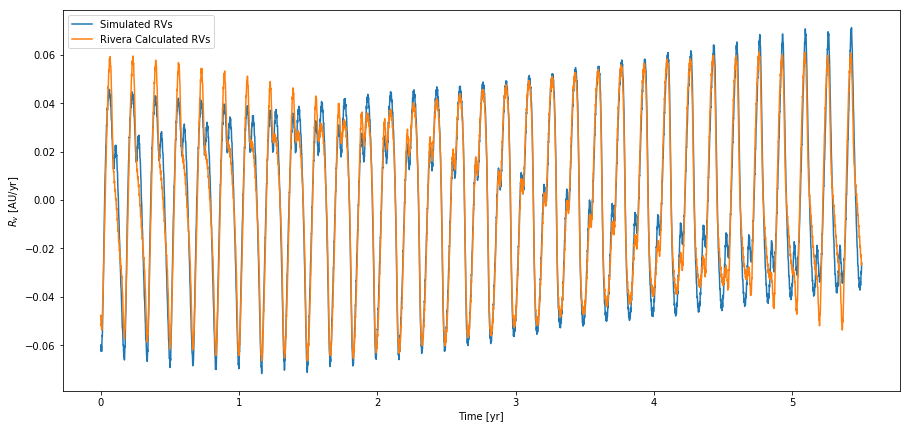

In [27]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(tt, rv, label='Simulated RVs')
plt.plot(tt, calcd_rvs, label='Rivera Calculated RVs')

ax.set_xlabel('Time [yr]')
ax.set_ylabel(r'$R_v$ [AU/yr]')

plt.legend();

## 3.1 Fit simulated RV with four Keplerian orbits. 

Obviously we can do better by minimizing the differences between the simulated and calculated RV curves and seeing what the new planet parameters are. We can do this via a simple chi square test.

In [28]:
# Chi-Squared function between data and model for that data with associated errors
def chiSquare(data, derr, model):
    '''Calculates the Chi square test between the data and the model weighted by the errors.'''
    return np.sum( (data-model)**2 / derr**2)


def boxedChiSquare(pparam, times, data, derr):
    '''Wrapper around chiSquare test that will perform limit checks on values of 
    eccentricity and periods. Relevant system data (P, e tp) is in pparam. Technically 
    usable for other purposes but data and errors are expected to be RV and RVerr.
    '''
    Ps = pparam[0::3]
    es = pparam[1::3]

    if np.any(es<0) or np.any(es>1) or np.any(Ps<0):
        # return large value to push the optimizer out
        return 1e20
    else:
        return chiSquare(data, derr, calcRV(times, data, derr, pparam))

In [29]:
# will take 30 mins - 1h depending on your machine
bestfit = optimize.minimize(lambda x : boxedChiSquare(x, tt, rv, rverr), pparam)

### 3.2 How big are the residuals?  How does this compare to typical RV errors?

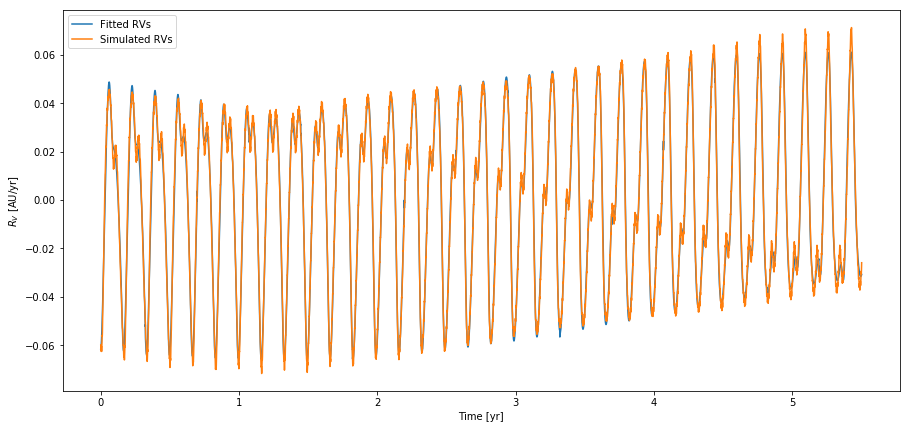

In [44]:
fittedrvs = calcRV(tt, rv, rverr, bestfit.x)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(tt, fittedrvs, label="Fitted RVs")
ax.plot(tt, rv, label="Simulated RVs")

ax.set_xlabel("Time [yr]")
ax.set_ylabel(r"$R_V$ [AU/yr]")

plt.legend();

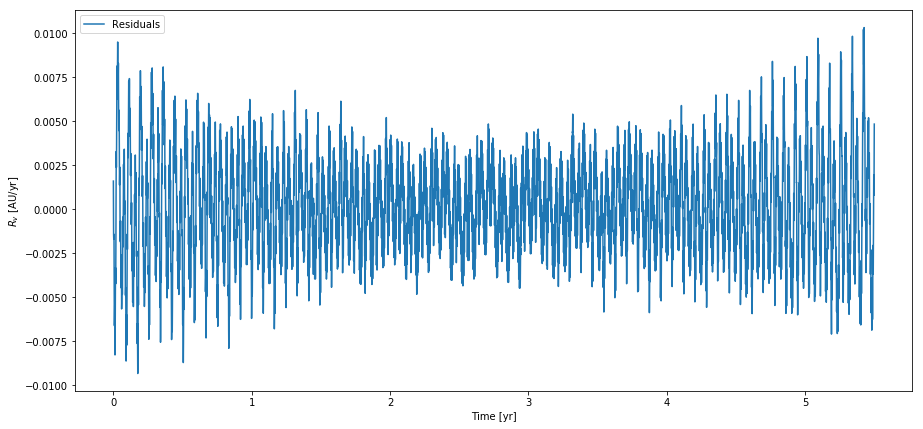

In [43]:
residuals = rv - fittedrvs

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(tt, residuals, label="Residuals")

ax.set_xlabel("Time [yr]")
ax.set_ylabel(r"$R_v$ [AU/yr]")

plt.legend();

The fitted planet parameters are:

In [89]:
header = 'Planet          {0:6} {1:6} {2:6} {3:6}'.format('d', 'c', 'b', 'e')
table = '''
Period [yr]  {0:6.3f} {3:6.3f} {6:6.3f} {3:6.3f}
Eccentricity {1:6.3f} {4:6.3f} {7:6.3f} {7:6.3f}
t_p [yr]     {2:0.3f} {5:0.3f} {8:0.3f} {11:0.3f}
'''
prtstr = header + table
print(prtstr.format(*res.x))

Planet          d      c      b      e     
Period [yr]   0.006  0.083  0.167  0.083
Eccentricity  0.205  0.157  0.055  0.055
t_p [yr]     -0.003 -0.008 -0.037 -0.052



The RVs are the largest on the edges of fitted times so we inspect two different regimes of values:

In [20]:
print(max(residuals), max(abs(residuals[(tt>2) & (tt<3)])))

0.010329474159647425 0.004849277029116614


0.01 AU/yr is approximately 50m/s while 0.004 AU/yr is approximately 20m/s.                 
Depending on the used instrument, this can be within the, or slightly larger than, error of the instrument for lower precission instrument and is 2-3 times larger than the expected error of the precise instruments.

## 4. Make a plot of the TTVs of GJ 876 c over 4 years (assuming edge-on, so that planet would transit). 

In [47]:
def calcTTV(planets, N=600, dt=0.00172021412, nplanet=1):
    """For given planets, number of transits and timestep dt runs a Rebound
    simulation keeping track of times when transits occur. Returns the transit
    number and simulated transit timing variation of that transit. 
    """
    sim = rebound.Simulation()
    sim.add(**star)
    for planet in pplan:
        sim.add(**planet)
    sim.move_to_com()

    transittimes = np.zeros(N)
    p = sim.particles

    i = 0
    while i<N:
        y_old = p[nplanet+1].y - p[0].y  # (Thanks to David Martin for pointing out a bug in this line!)
        t_old = sim.t
        sim.integrate(sim.t+dt) # check for transits every 0.5 time units. Note that 0.5 is shorter than one orbit
        t_new = sim.t
        if y_old*(p[nplanet+1].y-p[0].y)<0. and p[nplanet+1].x-p[0].x>0.:   # sign changed (y_old*y<0), planet in front of star (x>0)
            while t_new-t_old>1e-7:   # bisect until prec of 1e-5 reached
                if y_old*(p[nplanet+1].y-p[0].y)<0.:
                    t_new = sim.t
                else:
                    t_old = sim.t
                sim.integrate( (t_new+t_old)/2.)
            transittimes[i] = sim.t
            i += 1
            sim.integrate(sim.t+dt/10)       # integrate 0.05 to be past the transit
        
    A = np.vstack([np.ones(N), range(N)]).T
    c, m = np.linalg.lstsq(A, transittimes)[0]
    
    return np.asarray(range(N)), np.asarray((transittimes-m*np.array(range(N))-c)*(24.*365./2./np.pi))

In [48]:
pplan = copy.deepcopy(planets)
inc = np.pi/2
for planet in pplan:
    newm = calcMass(planet, inc)
    planet.inc = inc
    planet.m = newm

x1, y1 = calcTTV(pplan)

/home/dinob/anaconda3/envs/exoplanets/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Text(0, 0.5, 'TTV [hours]')

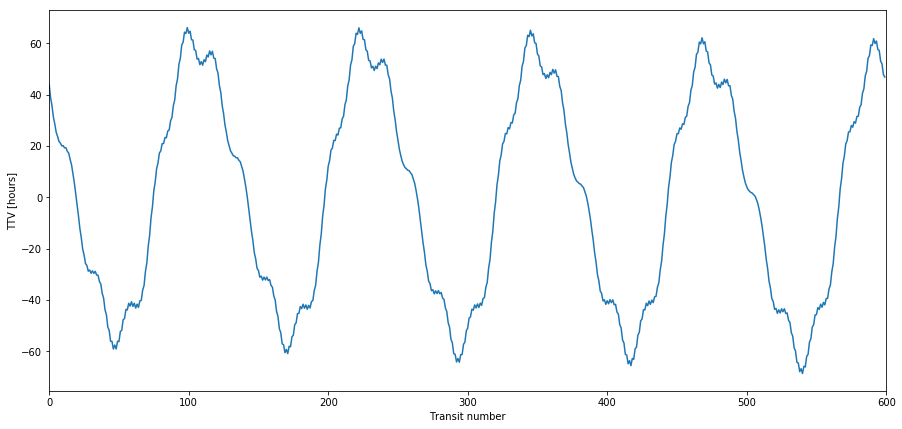

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(x1, y1);

ax.set_xlim([0, 600])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")

Hard to describe complicated curves like there over a handful parameters, but lets say if the curve were well approximated by a sine (which it won't be because the kinks will consistenly force a fitted sine to underestimate the peak values and the curve itself is not constant with number of transits) we can do least squares fitting to estimate the parameters of the curve.

Best fit parameters are amplitude=56.795622026851134, period=122.2210268696198, frequency=0.05140838256810116 and phase=2.2968230780963284.


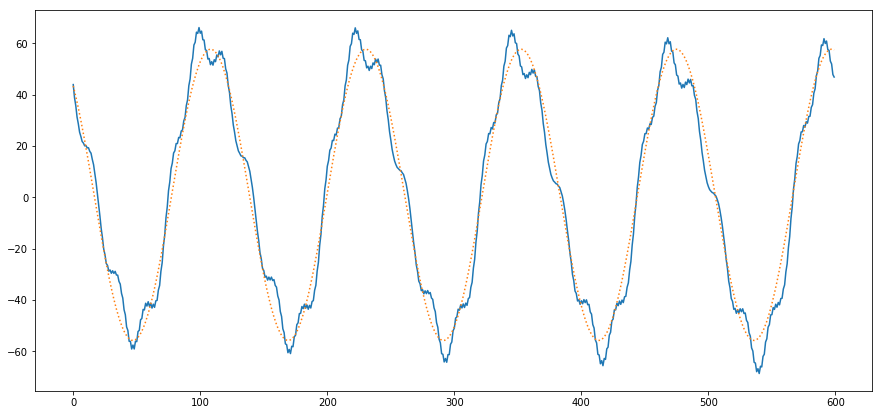

In [96]:
optimize_func = lambda x: x[0]*np.sin(x[1]*x1+x[2]) + x[3] - y1

mean = 0
phase = np.pi/2
freq = 0.05
amp = 80

amp, freq, phase, mean = optimize.leastsq(optimize_func, [amp, freq, phase, mean])[0]
fine_t = np.arange(0, len(x1) ,0.1)

data_fit=est_amp*np.sin(est_freq*x1+est_phase)+est_mean

fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(x1, y1, label='TTV')
ax.plot(x1, data_fit, ':', label='Best fit sine')

print(f'Best fit parameters are amplitude={amp}, period={2*np.pi/freq}, frequency={freq} and phase={phase}.')

### 3.1 How does it change if you vary the mass of GJ 876 b downward and upward by a factor of 2?

/home/dinob/anaconda3/envs/exoplanets/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Text(0, 0.5, 'TTV [hours]')

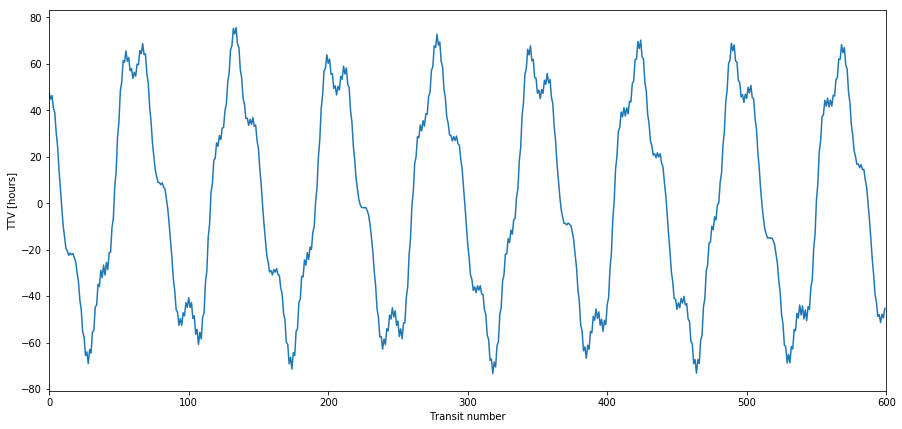

In [50]:
pplan[2].m *= 2

x2, y2 = calcTTV(pplan)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(x2, y2);
ax.set_xlim([0, 600])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")

/home/dinob/anaconda3/envs/exoplanets/lib/python3.7/site-packages/ipykernel_launcher.py:33: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Text(0, 0.5, 'TTV [hours]')

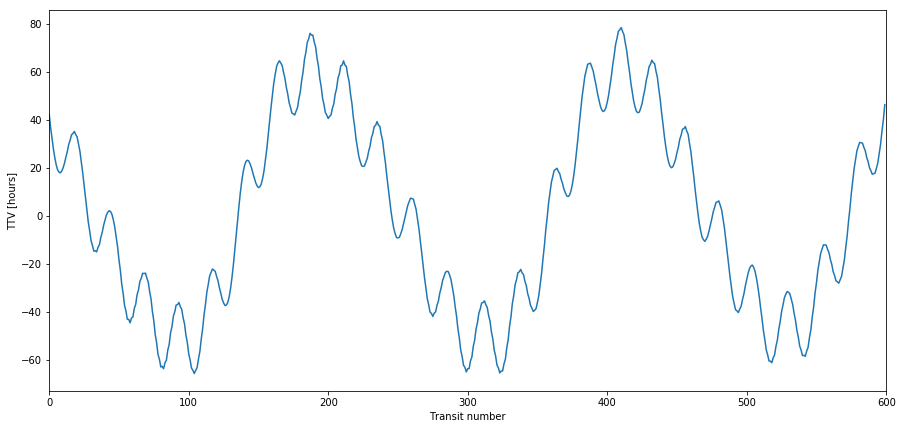

In [52]:
# note that divided by four to offset the doubling in mass above
pplan[2].m /= 4
x3, y3 = calcTTV(pplan)

fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(x3, y3);
ax.set_xlim([0, 600])
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")

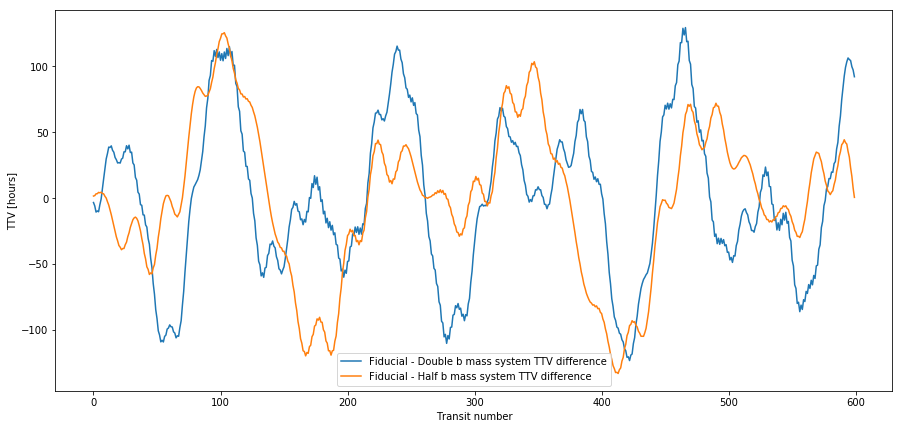

In [55]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))

ax.plot(x1, y1-y2, label='Fiducial - Double b mass system TTV difference')
ax.plot(x1, y1-y3, label='Fiducial - Half b mass system TTV difference')
ax.set_xlabel("Transit number")
ax.set_ylabel("TTV [hours]")

plt.legend()